In [ ]:
'''
AlexNet architecture
+---------+-----------------+-------------------------------+------------------+
| Layer   | Type            | Configuration                 | Output Size      |
+---------+-----------------+-------------------------------+------------------+
| Input   | Image           | 227 x 227 x 3 (RGB)           | 227 x 227 x 3    |
| Conv 1  | Convolution     | 96 filters (11x11), Stride 4  | 55 x 55 x 96     |
| Pool 1  | Max Pooling     | 3x3 window, Stride 2          | 27 x 27 x 96     |
| Conv 2  | Convolution     | 256 filters (5x5), Padding 2  | 27 x 27 x 256    |
| Pool 2  | Max Pooling     | 3x3 window, Stride 2          | 13 x 13 x 256    |
| Conv 3  | Convolution     | 384 filters (3x3), Padding 1  | 13 x 13 x 384    |
| Conv 4  | Convolution     | 384 filters (3x3), Padding 1  | 13 x 13 x 384    |
| Conv 5  | Convolution     | 256 filters (3x3), Padding 1  | 13 x 13 x 256    |
| Pool 3  | Max Pooling     | 3x3 window, Stride 2          | 6 x 6 x 256      |
| FC 6    | Fully Connected | 4096 Neurons + Dropout        | 4096             |
| FC 7    | Fully Connected | 4096 Neurons + Dropout        | 4096             |
| FC 8    | Fully Connected | 1000 Neurons (Softmax)        | 1000             |
+---------+-----------------+-------------------------------+------------------+

After the Conv3 and Conv4, we don't add MaxPool or AvgPool to avoid shrinking too quickly,
losing critical spatial information before the network could extract high-level features.
'''

In [3]:
#########################
## Importing libraries ##
#########################

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

from alive_progress import alive_bar, alive_it

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
#########################
## Dataset downloading ##
#########################
'''
Import CIFAR-10 dataset from HuggingFace
Run this first in terminal: pip install datasets
'''

from datasets import load_dataset

train_set = load_dataset(
    'cifar10',
    split='train', # Download the training set
    verification_mode='basic_checks'  # checks if the data files exist and verifies basic metadata
)

print(train_set)

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})


In [7]:
val_set =  load_dataset(
    'cifar10',
    split='test', # Download the training set
    verification_mode='basic_checks'  # checks if the data files exist and verifies basic metadata
)

print(val_set)

Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})


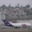

In [8]:
# View an image
train_set[0]['img']

In [9]:
print(train_set[0]['img'])
# <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7A2EBA2F0410>

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7D0995981AF0>


In [52]:
#########################
## Image preprocessing ##
#########################

IMG_SIZE = 32
'''
Most CNNs are designed to only accept images of a fixed size
=> Must fix the IMG_SIZE, and reshape the input to adapt this norm.
'''

#----
## Build preprocess transforms
#----

preprocess = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)), # Resize the input image to a given size (IMG_SIZE, IMG_SIZE)
        transforms.ToTensor()                  # Convert to tensor (and also convert to [0, 1] tensors)
    ]
)

#----
## Change from grayscale to RGB, and apply preprocess
#----

from tqdm.auto import tqdm

inputs_train = []

for record in tqdm(iterable=train_set, desc="Preprocessing Images"):
    image = record['img']
    label = record['label']
    
    # Convert from grayscale to RGB (3-colour channels)
    if image.mode == "L":
        image = image.convert("RGB")
        
    # preprocessing
    input_tensor = preprocess(image)
    label_tensor = torch.tensor(label)
    
    # append to inputs_train
    inputs_train.append([input_tensor, torch.tensor(label)])


Preprocessing Images:   0%|          | 0/50000 [00:00<?, ?it/s]

In [53]:
#----
## Re-normalize the pixel values for train set
#----
'''
Since transforms.Tensor() normalizes all into [0, 1],
we need to modify this normalization to fit this dataset.

Doing so by calculating the mean and std for all images across separe 3 color channles
then use transforms.Normalize(mean=, std=) with this calculated mean and std.
'''

# First, we need to calculate the mean and std for each of the RGB channels across all images

import numpy as np

# Choosing a random sample to calculate mean and std (this sample containing random 512 images)
np.random.seed(0)
idx = np.random.randint(0, len(inputs_train), 512)

# Concatenate this subset of images into a new tensor )tensor_placeholder)
tensor_placeholder = torch.concat([inputs_train[i][0] for i in idx], axis=1)
print(tensor_placeholder.shape)
# torch.Size([3, 16384, 32])
'''
we concatenate 512 images of size (3x32x32) (Channel*Height*Width) along the Height channel
=> (3x16384x32), 16384=32*512
'''

# Calculate the mean and std across all images, for separate channel
mean_all = torch.mean(tensor_placeholder, dim=(1, 2)) # dim=(1, 2) meanin only uses Heigh*Width for calculation, ignore the channel
std_all = torch.std(tensor_placeholder, dim=(1, 2))

print(mean_all) # tensor([0.4855, 0.4792, 0.4421])
print(std_all) # tensor([0.2464, 0.2418, 0.2599])

#### RE-NORMALIZE ###

preprocess = transforms.Compose([transforms.Normalize(mean=mean_all, std=std_all)])

for idx in tqdm(range(len(inputs_train))):
    input_tensor = preprocess(inputs_train[idx][0])
    inputs_train[idx][0] = input_tensor # replace with re-normalized tensor

torch.Size([3, 16384, 32])
tensor([0.4855, 0.4792, 0.4421])
tensor([0.2464, 0.2418, 0.2599])


  0%|          | 0/50000 [00:00<?, ?it/s]

In [54]:
#----
## Re-normalize the pixel values for val set
#----

preprocess = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)), # Resize the input image to a given size (IMG_SIZE, IMG_SIZE)
        transforms.ToTensor(),                  # Convert to tensor (and also convert to [0, 1] tensors)
        transforms.Normalize(mean=mean_all, std=std_all) # Re-normalize with new mean and std
    ]
)

inputs_val = []

for record in tqdm(iterable=val_set, desc="Preprocessing Images"):
    image = record['img']
    label = record['label']
    
    # Convert from grayscale to RGB (3-colour channels)
    if image.mode == "L":
        image = image.convert("RGB")
        
    # preprocessing
    input_tensor = preprocess(image)
    label_tensor = torch.tensor(label)
    
    # append to inputs_train
    inputs_val.append([input_tensor, torch.tensor(label)])

Preprocessing Images:   0%|          | 0/10000 [00:00<?, ?it/s]

In [55]:
################
## Dataloader ##
################

BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(inputs_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(inputs_val, batch_size=BATCH_SIZE, shuffle=False)

In [64]:
###################################
## Building AlexNet-inspired CNN ##
###################################
'''
At each block, the images are downsampled by the max-pooling layer. 

Contrary, the number of channels from one layer to another increased from 3 to 64, to 192, ... to 256. 
=> As we learned before, deeper layers have larger receptive fields and generally detect more specific and complex features, 
such as ears, eyes, or even human faces and dogs. The chosen filter (or kernel) size is either or even human faces and dogs.

How will it increase from 3 channels to 64 channels?
    => The layer creates 64 separate filters (kernels), where each filter processes all 3 input channels together
    => Each has shape: 4x4x3 (kernel_size=4, and depth=3 to match input channels)
    => Filter 1 (4x4x3) convolves with RGB input → produces feature map 1
       Filter 2 (4x4x3) convolves with RGB input → produces feature map 2
       ...
       Filter 64 (4x4x3) convolves with RGB input → produces feature map 64
    => Stack all 64 feature maps together = 64 output channels

The kernel_size refers to the height and width of the sliding window (also called filter)
The chosen filter (or kernel) size is either 3 or 4. Example, kernel_size=4 => sliding window is 4x4
This is a common choice - having a smaller filter allows the network to better generalize. 

Padding is the process of adding a "border" of extra pixels (usually zeros) around the edges of your input image before the convolution operation begins.
Padding helps avoid shrinkage and loss of edge information.
=> Here, padding is 1 pixel on each layer.
'''

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            # Block 1: conv -> relu -> max_pool
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Block 2: conv -> relu -> max_pool
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Block 3: conv -> relu
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(),
            
            # Block 4: conv -> relu
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
                       
            # Block 5: conv -> relu -> max_pool
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Convolutional and pooling layers output 4D tensors (Batch, Channels, Height, Width)
            # However, Fully Connected layers expect 2D tensors (Batch, Features)
            # => must FLATTEN the 4D tensor into a 2D tensor
            nn.Flatten(),
                        
            # Block 6: drop_out -> fc_linear -> relu
            nn.Dropout(p=0.5),
            nn.LazyLinear(512), # nn.Linear() requires input_size (1024) and output_size, using nn.LazyLinear() will automaticall calculate the input_size for us
            nn.ReLU(),
            
            # Block 7: drop_out -> fc_linear -> relu
            nn.Dropout(p=0.5),
            nn.LazyLinear(256), # nn.Linear() requires input_size (1024) and output_size, using nn.LazyLinear() will automaticall calculate the input_size for us
            nn.ReLU(),
            
            
            # Block 8: fc_linear -> final logits (output)
            nn.LazyLinear(num_classes)
        )
        
    def forward(self, X):
        out = self.cnn(X)
        return out


In [67]:
##########################
## model initialization ##
##########################

num_classes = len(set(train_set['label']))
print(num_classes) # 10

torch.manual_seed(42)
model = AlexNet(num_classes=num_classes).to(device)

##################################
## Loss - Optimizer - Scheduler ##
##################################

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.2)

10


In [ ]:
################################
## Training - Validating loop ##
################################

epochs = 100

train_loss_list, val_loss_list = [], []

for epoch in tqdm(iterable=range(1, epochs+1, 1), desc="Training"):
    # --- TRAINING ---
    _ = model.train() # Turn on training mode, enable gradient tracking
    for _, (images, labels) in enumerate(train_loader):
        # moves values to device
        images = images.to(device)
        labels = labels.to(device)
        
        # (Standard training steps: forward, loss, zero_grad, backward, step)
        preds = model(images).squeeze()
        loss = loss_fn(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # --- VALIDATION (Every epoch) ---
    _ = model.eval() # 1. Set model to evaluation mode
    val_loss = 0
    with torch.inference_mode(): # 2. Turn off gradient tracking to save memory
        for _, (images, labels) in enumerate(val_loader): # 3. Iterate through val_set
            # moves values to device
            images = images.to(device)
            labels = labels.to(device)
            
            # calculate predictions
            val_preds = model(images).squeeze()
            
            # Accumulate loss to get an average for the whole set
            val_loss += loss_fn(val_preds, labels).item()
            
            # Calculate accuracy
            
    
    avg_val_loss = val_loss / len(val_loader)
    
    train_loss_list.append(loss.item())
    val_loss_list.append(avg_val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    
    scheduler.step(avg_val_loss)
    
    if epoch % 10 == 0:
        print("+"*50)
        print(f"Epoch: {epoch}")
        print(f"Train loss: {loss:.4f}")
        print(f"Validation loss: {avg_val_loss:.4f}")
        print(f"Current LR: {current_lr}")

Training:   0%|          | 0/100 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 10
Train loss: 2.2106
Validation loss: 2.0176
Current LR: 0.0050
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 20
Train loss: 2.2526
Validation loss: 2.2554
Current LR: 0.0010
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 30
Train loss: 2.1977
Validation loss: 2.1842
Current LR: 0.0000
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 40
Train loss: 2.3100
Validation loss: 2.1797
Current LR: 0.0000
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 50
Train loss: 2.2538
Validation loss: 2.1797
Current LR: 0.0000
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 60
Train loss: 2.1119
Validation loss: 2.1797
Current LR: 0.0000
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 70
Train loss: 2.0938
Validation loss: 2.1797
Current LR: 0.0000
++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch: 80
Train loss: 2.2248
Validation loss: 2.1797
Current LR: 0.0000
++++++++++++++++